Σημειώσεις:
- Η εργασία είναι ομαδική, με μέγιστο αριθμό ατόμων τα 2.
- Κάθε ομάδα θα πρέπει να παραδώσει ένα Google Colab notebook με τις λύσεις και τις επεξηγήσεις τους.
- Οι λύσεις θα ελεγχθούν ως προς την ομοιότητά τους (software wise).

# Task 1 - Προεργασία [0.25]

Στο παρόν task, πρέπει να λάβετε ένα occupancy grid map από το διαδίκτυο, να το φορτώσετε σε ένα αντικείμενο της OpenCV και να το εμφανίσετε σαν output.

- Παράδειγμα OGM: https://raw.githubusercontent.com/stdr-simulator-ros-pkg/stdr_simulator/indigo-devel/stdr_resources/maps/hospital_section.png 
- Σχόλια
  - Μπορείτε να χρησιμοποιήσετε την `skimage`.
  - Για να εμφανίσετε εικόνα στο Google colab πρέπει να χρησιμοποιήσετε το `from google.colab.patches import cv2_imshow`
  - Κάθε pixel της εικόνας θεωρούμε ότι έχει διάσταση 5x5 cm.

In [1]:
# Here make all the necessary imports
import cv2
import matplotlib.pyplot as plt
import random
# from google.colab.patches import cv2_imshow

In [2]:
image = cv2.imread('./hospital_section.png')

# if image has 3 channels, convert it to grayscale and binarize it
def binarize(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the image to get the binary image
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return image

# if image has 3 channels, convert it to grayscale and inverse binarize it
def binarize_inv(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Getting the inverse binary threshold because the occupied area in picture is black so this is 0 but we want the occupied area to be 255(1) so we invert the threshold
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    return image

    
# A function to show the image
def show_image(image, title, spacing=100):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(title)
    # ax show image
    ax.set_xticks([x for x in range(0, image.shape[1], spacing)])
    ax.set_xticklabels([5*x for x in range(0, image.shape[1], spacing)])
    ax.set_yticks([y for y in range(0, image.shape[0], spacing)])
    ax.set_yticklabels([5*y for y in range(0, image.shape[0], spacing)])
    ax.imshow(image, cmap='gray')


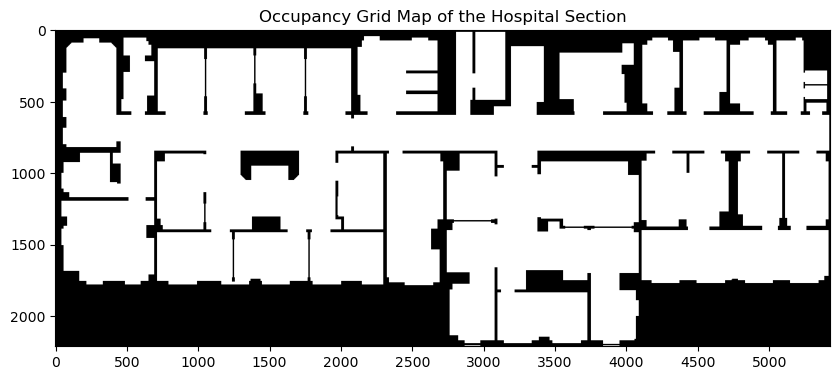

In [3]:
image_normal = binarize(image)
show_image(image_normal, title='Occupancy Grid Map of the Hospital Section')

# Task 2 - BrushFire [0.5]

Στο παρόν task, πρέπει να υπολογίσετε το brushfire value field του παραπάνω OGM, με τις εξής παραδοχές:
- Θα εφαρμόζεται στον ελεύθερο χώρο
- Θα ξεκινά από τα εμπόδια
- Θα τερματίζει όταν δεν θα μπορεί να εκτελέσει άλλη εξάπλωση

Καλείστε να δημιουργήσετε μία νέα εικόνα η οποία θα αναπαριστά το brushfire field και να την εμφανίσετε.

In [4]:
import numpy as np

In [5]:
# Brushfire Algorithm for a given image
def brushfire(image):
    # Create a copy of the image in order not to modify the original one
    image_copy = image.copy()
    # Get the dimensions of the image
    height, width = image_copy.shape
    # Create a numpy array of the same size as the image with all zeros in order to initialize the distance map
    distance = np.zeros((height, width), dtype=np.uint8)
    # Create a queue for the pixels that will be used later on to calculate the distances list
    queue = []
    
    # Loop through the image and add the pixels that are occupied to the queue
    for y in range(height):
        for x in range(width):
            # If the pixel is occupied, add it to the queue and assign it a distance of 1
            if image[y, x] == 255:
                queue.append((y, x))
                distance[y, x] = 1

    # Loop through the queue and add the pixels that are unoccupied to the queue
    while queue:
        # While we have data in the queue, pop the first element and assign it to y and x
        y, x = queue.pop(0)
        # Then for each of the 4 neighbors UP, DOWN, LEFT, RIGHT
        for dy, dx in ((-1, 0), (1, 0), (0, -1), (0, 1)):
            y2, x2 = y + dy, x + dx
            # Check if the neighbor is within the image regions and if the distance is 0 meaning that is not yet assigned proceed to the if statement
            if 0 <= y2 < height and 0 <= x2 < width and distance[y2, x2] == 0:
                # Assign the distance of the neighbor + 1
                distance[y2, x2] = distance[y, x] + 1
                # Add the neighbor to the queue in order to check its neighbors later on
                queue.append((y2, x2))

    # Finally return the distance map
    return distance

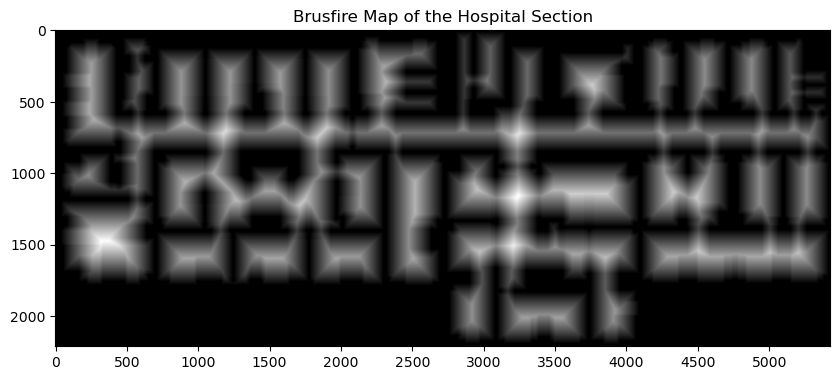

In [6]:
# We need to get the inverse here because the occupied regions have the 255 value in the image
inv_image = binarize_inv(image)
brushfire_map = brushfire(inv_image)
show_image(brushfire_map, 'Brusfire Map of the Hospital Section')

# Task 3 - Uniform PRM [0.5]

Υλοποιήστε ομοιόμορφη δειγματοληψία στον ελεύθερο χώρο, ούτως ώστε να δημιουργήσετε μία δομή γράφου, στην οποία θα μπορεί να εκτελεστεί αλγόριθμος αναζήτησης γράφου. Επίσης σχεδιάστε τον γράφο στην αρχική εικόνα και εμφανίστε τον.


In [7]:
# Create a class of a node that contains it's id, x and y coordinates and a list of neighbors
class Node:
  def __init__(self, id, x, y):
    self.id = id
    self.x = x
    self.y = y
    self.neighbors = [] # list of ids

# Create a graph class that contains a list of nodes
class Graph:
  def __init__(self):
    self.nodes = [] # list of Node instances

In [8]:
# Make a function than makes uniform sampling of points based on a given brushfire map and step size
def uniform_sampling(image, brushfire_map, step, threshold=1):
    # Initialize the graph
    graph = Graph()
    # Get the dimensions of the image
    height, width = image.shape
    # Create a counter for the ids of the nodes
    id_counter = 0
    # Loop through the image and add the points that are unoccupied to the list
    for x in range(0, width, step):
        for y in range(0, height, step):
            # If the pixel is unoccupied, add it to the list
            if image[y, x] > 1 and brushfire_map[y, x] > threshold:
                # Create a node instance
                current_node = Node(id_counter, x, y)
                # Increment id_counter
                id_counter += 1
                # Add the created node to the graph
                graph.nodes.append(current_node)
                # Now check for the neighbors of the node
                for di, dj in ((-step, 0), (-step, -step), (0, -step), (-step, +step)):
                    y2, x2 = y + dj, x + di
                    if 0 <= y2 < height and 0 <= x2 < width and image[y2, x2] > 1 and brushfire_map[y2, x2] > threshold:
                        # Search if the checked node is already in the graph and if it is add it to the neighbors list of the current node
                        for node in graph.nodes:
                            if node.x == x2 and node.y == y2:
                                # Connect the nodes
                                if node not in current_node.neighbors:
                                    current_node.neighbors.append(node)
                                if current_node not in node.neighbors:
                                    node.neighbors.append(current_node)
                                break
                
    # Finally return the list of points
    return graph

In [9]:
# Create a function to display the probabilistic roadmap with the nodes and the edges
def show_graph(graph, image, brushfire_map, title):
    x = []
    y = []
    for node in graph.nodes:
        x.append(node.x)
        y.append(node.y)
        
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.axis('off');
    plt.scatter(x, y, s=1, c='black', marker='o');

    # Draw the lines between the nodes
    image_copy = image.copy()
    for node in graph.nodes:
        for neighbor in node.neighbors:
            cv2.line(image_copy, (node.x, node.y+1), (neighbor.x, neighbor.y+1), (0,0,0), 1) 
    
    plt.imshow(brushfire_map, cmap='gray', alpha=0.9);
    plt.imshow(image_copy, cmap='gray', alpha=0.3);
    plt.show()

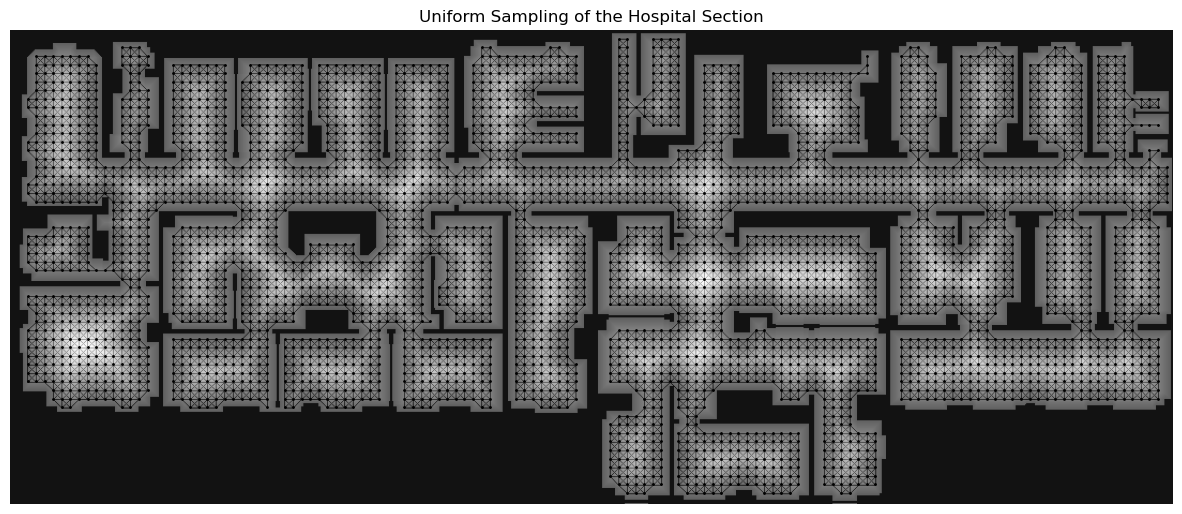

In [10]:
uniform_probalistic_roadmap = uniform_sampling(image_normal, brushfire_map, step=8, threshold=5)
show_graph(uniform_probalistic_roadmap, image_normal, brushfire_map, 'Uniform Sampling of the Hospital Section')

# Task 4 - Random PRM [0.5]

Υλοποιήστε τυχαία δειγματοληψία στον ελεύθερο χώρο, ούτως ώστε να δημιουργήσετε μία δομή γράφου, στην οποία θα μπορεί να εκτελεστεί αλγόριθμος αναζήτησης γράφου. Επίσης σχεδιάστε τον γράφο στην αρχική εικόνα και εμφανίστε τον.


In [11]:
# Make a function than makes random sampling of points based on a given brushfire map
def random_sampling(image, brushfire, num_samples, one_pass_neighbor_calculation=False, radius=5, threshold=1):
    # Initialize the graph
    graph = Graph()
    # Get the dimensions of the image
    height, width = image.shape
    # Create a counter for the ids of the nodes
    id_counter = 0
    # Loop through the image and add the points that are unoccupied to the list
    for i in range(num_samples):
        # Get random x and y location on the image
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        # Check if the random location it is not already got by another node
        flag_already_exists = False
        for node in graph.nodes:
            if node.x == x and node.y == y:
                flag_already_exists = True
        # If the pixel is unoccupied, add it to the list
        if (brushfire[y,x] > threshold) & (image[y,x] > 1 ) & (flag_already_exists == False):
            # Create a node instance
            current_node = Node(id_counter, x, y)
            # Increment id_counter
            id_counter += 1
            # Add the created node to the graph
            graph.nodes.append(current_node)
            # Calculate neighbors on the fly while adding new node
            if one_pass_neighbor_calculation == False:
                for node in graph.nodes:
                    # If the distance between the nodes is less than the threshold radius connect them
                    if np.sqrt((node.x - x)**2 + (node.y - y)**2) < radius:
                        # Connect the current node to the node
                        if node not in current_node.neighbors:
                            current_node.neighbors.append(node)
                        # Connect the node to the current node
                        if current_node not in node.neighbors:
                            node.neighbors.append(current_node)
                    
    # Calculate all neighbors in one pass 
    if one_pass_neighbor_calculation == True:
        # For every node in the graph
        for node in graph.nodes:
            # Check every other node in the graph
            for node2 in graph.nodes:
                # If the node is not the same
                if node.id != node2.id:
                    # If the distance between the nodes is less than the radius
                    if np.sqrt((node.x - node2.x)**2 + (node.y - node2.y)**2) < radius:
                        node.neighbors.append(node2)
                
    # Finally return the list of points
    return graph

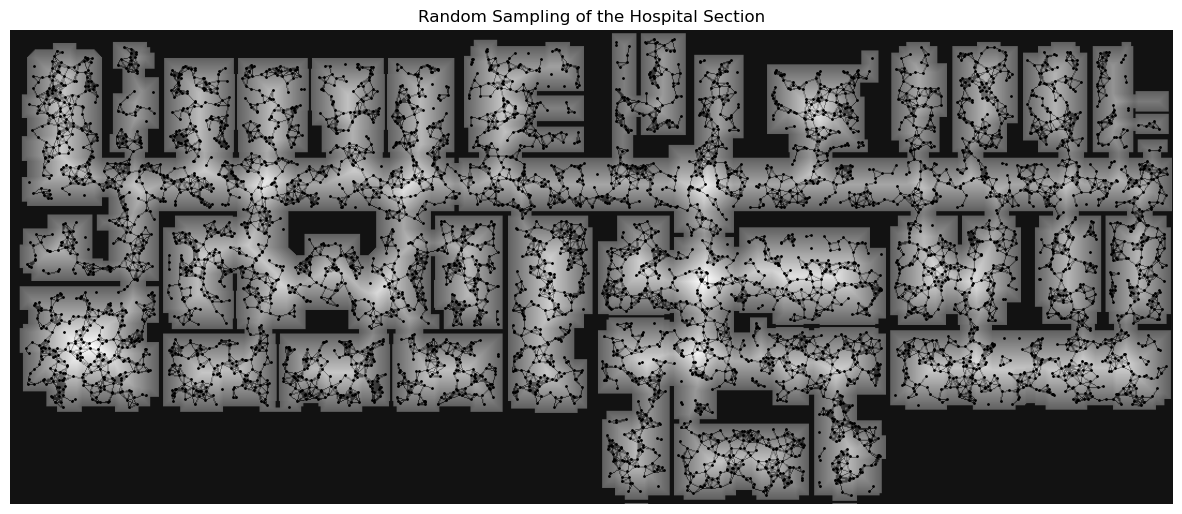

In [12]:
# Use random sampling to get a list of N points on the map with neighbors calculated in one loop and they get assigned if radius is less than X meters
random_probalistic_roadmap = random_sampling(image_normal, brushfire_map, num_samples=10000, one_pass_neighbor_calculation=True, radius=10, threshold=5)
show_graph(random_probalistic_roadmap, image_normal, brushfire_map, 'Random Sampling of the Hospital Section')

# Task 5 - Dijkstra & A* [0.75]

Υλοποιήστε τις συναρτήσεις `dijkstra` και `a_star` στην κλάση `Graph` οι οποίες θα λαμβάνουν ως όρισμα δύο κόμβους του γράφου και θα επιστρέφουν:
- Το μονοπάτι από τον έναν στον άλλον κόμβο
- Τα expansions (searches) που έγιναν κατά την αναζήτηση

Επίσης σχεδιάστε το μονοπάτι στην αρχική εικόνα και εμφανίστε το.

In [13]:
# Create fake nodes
index = 0;
test_graph = Graph()
for i in range(0,10,2):
    for j in [0 , 2]:
        fake_node = Node(index, i, j)
        index += 1
        test_graph.nodes.append(fake_node)
for node in test_graph.nodes:
    for node2 in test_graph.nodes:
        if node.id != node2.id:
            if np.sqrt((node.x - node2.x)**2 + (node.y - node2.y)**2) < 2.1:
                node.neighbors.append(node2)

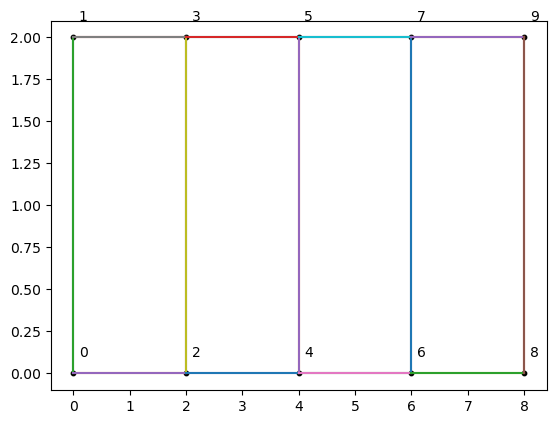

In [14]:
# This one is for test purposes and debugging the code
x = []
y = []
for node in test_graph.nodes:
    x.append(node.x)
    y.append(node.y)
for node in test_graph.nodes:
    for neighbor in node.neighbors:
        plt.plot((node.x, neighbor.x), (node.y, neighbor.y)) 
for node in test_graph.nodes:
    # Add text next to the node
    plt.text(node.x+0.1, node.y+0.1, node.id, fontsize=10, color='black')
plt.scatter(x, y, s=10, c='black', marker='o');

In [15]:
# Create Dijkstra's algorithm function for a given graph and a start and end node
def dijkstra(graph, start_node, end_node):
    # Create visited and unvisited lists
    visited_nodes = []
    unvisited_nodes = []
    # Create a list to keep track of the information of the nodes for the dijkstra algorithm
    information_list = []
    for node in graph.nodes:
        # Create a dictionary for the information of the node
        node_information = {}
        # Set the distance of the node to infinity
        node_information['distance'] = np.inf
        # Set the previous node to None
        node_information['previous'] = None
        #  Set the node to unvisited
        node_information['node'] = node
        # Add the information to the list
        information_list.append(node_information)

    # Set the distance of the start node to 0
    information_list[start_node.id]['distance'] = 0

    # Add the start node to the unvisited list
    unvisited_nodes.append(information_list[start_node.id])

    flag_found_the_end_node = False

    # While there are still unvisited nodes
    while len(unvisited_nodes) > 0:
        # Assign the current node to the node with the smallest distance
        current_node = sorted(unvisited_nodes, key=lambda k: k['distance'])[0]
        # Remove the current node from the unvisited list
        unvisited_nodes = list(filter(lambda k: k['node'].id != current_node['node'].id, unvisited_nodes))
        # Add the current node to the visited list
        visited_nodes.append(current_node['node'].id)

        # If the current node is the end node
        if current_node['node'] == end_node:
            # Break the loop
            flag_found_the_end_node = True
            break


        # For every neighbor of the current node
        for neighbor in current_node['node'].neighbors:
            # Calculate the distance to the neighbor
            distance = current_node['distance'] + np.sqrt((current_node['node'].x - neighbor.x)**2 + (current_node['node'].y - neighbor.y)**2)
            # If the distance is smaller than the current distance of the neighbor
            if distance < information_list[neighbor.id]['distance']:
                # Update the distance of the neighbor
                information_list[neighbor.id]['distance'] = distance
                # Update the previous node of the neighbor
                information_list[neighbor.id]['previous'] = current_node['node']
                # If the neighbor is not in the unvisited list or visited list
            if (neighbor.id not in visited_nodes) & (neighbor.id not in list(map(lambda k: k['node'].id, unvisited_nodes))):
                # Add the neighbor to the unvisited list
                unvisited_nodes.append(information_list[neighbor.id])

    if flag_found_the_end_node == False:
        print('Could not find the end node')
        return None, visited_nodes
    else:
        # Create a list for the path
        path = []
        # Get the last visited node
        u = visited_nodes[-1]
        path.append(u)
        while information_list[u]['previous'] != None:
            path.append(information_list[u]['previous'].id)
            u = information_list[u]['previous'].id
                
        return path, visited_nodes

In [16]:
# Create A* algorithm function for a given graph and a start and end node, it is the same as dijkstra's algorithm but with the general distance from the end node
def a_star(graph, start_node, end_node):
    # Create visited and unvisited lists
    visited_nodes = []
    unvisited_nodes = []
    # Create a list to keep track of the information of the nodes for the dijkstra algorithm
    information_list = []
    for node in graph.nodes:
        # Create a dictionary for the information of the node
        node_information = {}
        # Set the distance of the node to infinity
        node_information['distance'] = np.inf
        # Calculate the general distance from the end node
        node_information['goal_distance'] = np.sqrt((node.x - end_node.x)**2 + (node.y - end_node.y)**2)
        # Set the general score of the node
        node_information['score'] = np.inf
        # Set the previous node to None
        node_information['previous'] = None
        # Set the node to unvisited
        node_information['node'] = node
        # Add the information to the list
        information_list.append(node_information)

    # Set the distance of the start node to 0
    information_list[start_node.id]['distance'] = 0
    information_list[start_node.id]['score'] = information_list[start_node.id]['distance'] + information_list[start_node.id]['goal_distance']

    # Add the start node to the unvisited list
    unvisited_nodes.append(information_list[start_node.id])
    flag_found_the_end_node = False

    # While there are still unvisited nodes
    while len(unvisited_nodes) > 0:
        # Assign the current node to the node with the smallest general score (distance + general distance)
        # This is the only difference with dijkstra's algorithm
        current_node = sorted(unvisited_nodes, key=lambda k: k['score'])[0]
        # Remove the current node from the unvisited list
        unvisited_nodes = list(filter(lambda k: k['node'].id != current_node['node'].id, unvisited_nodes))
        # Add the current node to the visited list
        visited_nodes.append(current_node['node'].id)

        # If the current node is the end node
        if current_node['node'] == end_node:
            # Break the loop
            flag_found_the_end_node = True
            break


        # For every neighbor of the current node
        for neighbor in current_node['node'].neighbors:
            # Calculate the distance to the neighbor
            distance = current_node['distance'] + np.sqrt((current_node['node'].x - neighbor.x)**2 + (current_node['node'].y - neighbor.y)**2)
            # If the distance is smaller than the current distance of the neighbor
            if distance < information_list[neighbor.id]['distance']:
                # Update the distance of the neighbor
                information_list[neighbor.id]['distance'] = distance
                # Update the score of the neighbor (distance + general distance)
                information_list[neighbor.id]['score'] = information_list[neighbor.id]['distance'] + information_list[neighbor.id]['goal_distance']
                # Update the previous node of the neighbor
                information_list[neighbor.id]['previous'] = current_node['node']
                # If the neighbor is not in the unvisited list or visited list
            if (neighbor.id not in visited_nodes) & (neighbor.id not in list(map(lambda k: k['node'].id, unvisited_nodes))):
                # Add the neighbor to the unvisited list
                unvisited_nodes.append(information_list[neighbor.id])

    if flag_found_the_end_node == False:
        print('Could not find the end node')
        return None, visited_nodes
    else:
        # Create a list for the path
        path = []
        # Get the last visited node
        u = visited_nodes[-1]
        path.append(u)
        while information_list[u]['previous'] != None:
            path.append(information_list[u]['previous'].id)
            u = information_list[u]['previous'].id
                
        return path, visited_nodes


In [17]:
# Create a function to show the graph and the path that was detected
def show_path(graph, path, start_node, end_node, image, brushfire_map, title):
    x = []
    y = []
    for node in graph.nodes:
        x.append(node.x)
        y.append(node.y)
        
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.axis('off');
    plt.scatter(x, y, s=1, c='black', marker='o');

    x_path = []
    y_path = []
    for i in range(len(path)):
        node = graph.nodes[path[i]]
        x_path.append(node.x)
        y_path.append(node.y)

    # Mark the starting node and the end node 
    plt.scatter(x_path, y_path, s=5, c='white', marker='o');
    plt.scatter(start_node.x, start_node.y, s=20, c='white', marker='o');
    plt.scatter(end_node.x, end_node.y, s=20, c='white', marker='X');
    plt.text(start_node.x + 10, start_node.y, 'Start', fontsize=10, color='white')
    plt.text(end_node.x + 10, end_node.y, 'End', fontsize=10, color='white')

    # Draw the lines between the nodes
    image_copy = image.copy()
    for node in graph.nodes:
        for neighbor in node.neighbors:
            cv2.line(image_copy, (node.x, node.y+1), (neighbor.x, neighbor.y+1), (0,0,0), 1) 

    for i in range(len(x_path)-1):
        # Draw white line between the nodes with cv2.line
        cv2.line(image_copy, (x_path[i], y_path[i]), (x_path[i+1], y_path[i+1]), (0,255,0), 5)

    plt.imshow(brushfire_map, cmap='gray', alpha=0.9);
    plt.imshow(image_copy, cmap='gray', alpha=0.3);
    plt.show()

In [18]:
# Create a function that draws 2 random nodes from the map and returns them
def get_random_nodes(graph):
    # Get a random node from the graph
    start_node = graph.nodes[np.random.randint(0, len(graph.nodes))]
    # Get a random node from the graph
    target_node = graph.nodes[np.random.randint(0, len(graph.nodes))]
    # Return the random nodes
    return start_node, target_node

In [19]:
def random_dijkstra(graph, brushfire_map, image, title):
    # Get 2 random nodes from the graph
    start_node, target_node = get_random_nodes(graph)
    # Get the path from the start node to the end node
    path, visited_nodes = dijkstra(graph, start_node, target_node)
    if path == None:
        print('Could not find the end node')
    else:
        # Print how many nodes were visited
        print('Number of visited nodes: ', len(visited_nodes))
        # Show the path
        show_path(graph, path, start_node, target_node, image, brushfire_map, title)

In [20]:
def random_a_star(graph, brushfire_map, image, title):
    # Get 2 random nodes from the graph
    start_node, target_node = get_random_nodes(graph)
    # Get the path from the start node to the end node
    path, visited_nodes = a_star(graph, start_node, target_node)
    if path == None:
        print('Could not find the end node')
    else:
        # Print how many nodes were visited
        print('Number of visited nodes: ', len(visited_nodes))
        # Show the path
        show_path(graph, path, start_node, target_node, image, brushfire_map, title)

Number of visited nodes:  1840


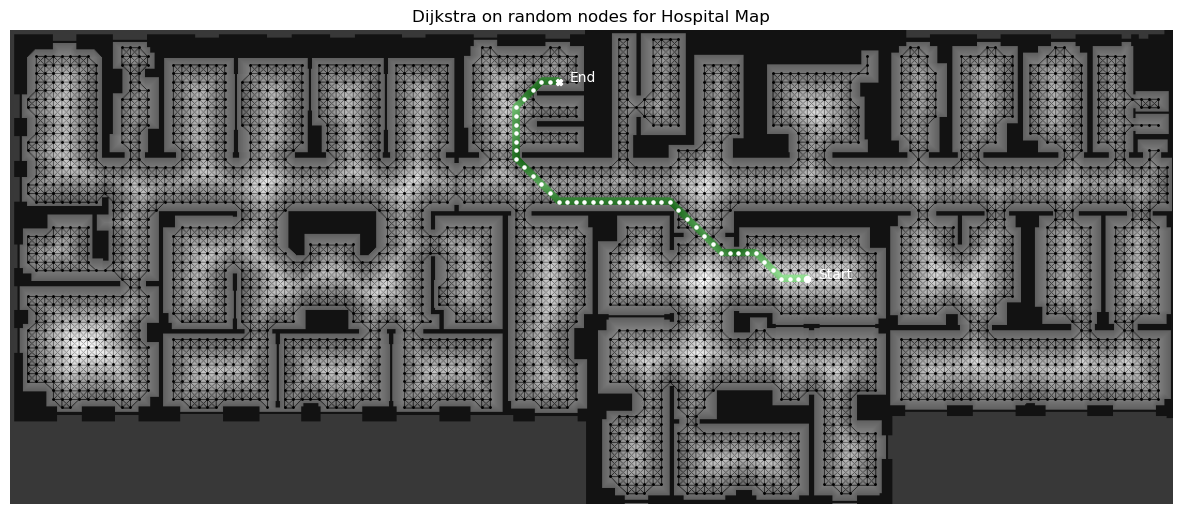

In [21]:
random_dijkstra(uniform_probalistic_roadmap, brushfire_map, image, 'Dijkstra on random nodes for Hospital Map')

Number of visited nodes:  62


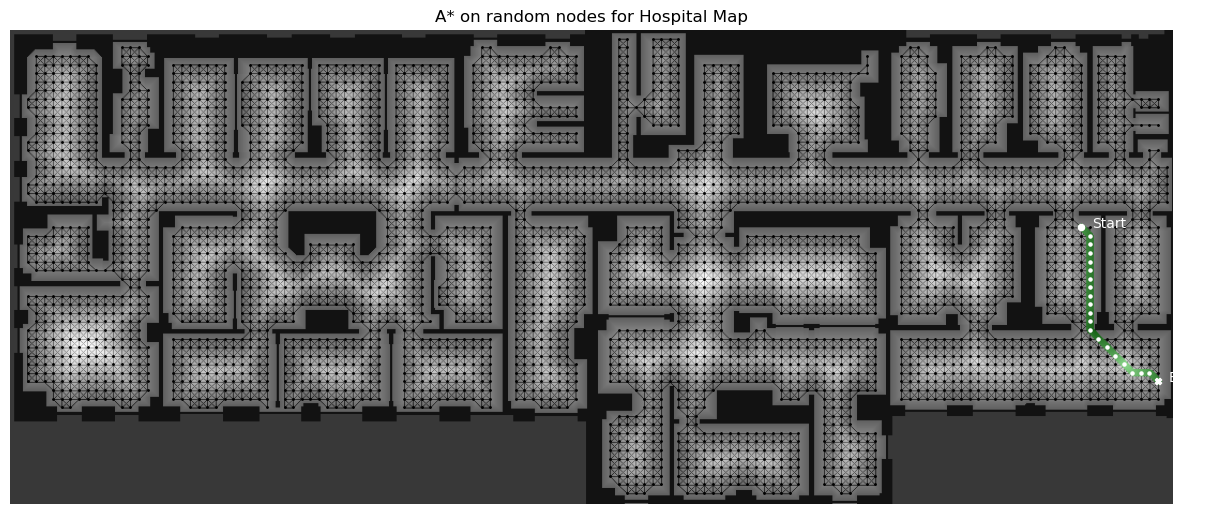

In [22]:
random_a_star(uniform_probalistic_roadmap, brushfire_map, image, title='A* on random nodes for Hospital Map')

# Task 6 - RRT [0.75]

Έχοντας ως είσοδο δύο κόμβους του γράφου, υλοποιήστε τον αλγόριθμο RRT, ο οποίος θα πρέπει να επιστρέφει το μονοπάτι από τον ένα κόμβο προς τον άλλον. Επίσης σχεδιάστε το RRT στην αρχική εικόνα και εμφανίστε το.

In [23]:
# Create a function than finds the point with the max distance from a starting point to target point
def find_max_distance_point(start_x, start_y, target_x, target_y, max_distance):
    # Calculate the angle between the start point and the target point
    angle = np.arctan2(target_y - start_y, target_x - start_x)
    # Calculate the x and y coordinates of the point
    distance = np.sqrt((target_x - start_x)**2 + (target_y - start_y)**2)
    if distance > max_distance:
        x = start_x + max_distance * np.cos(angle)
        y = start_y + max_distance * np.sin(angle)
    else:
        x = target_x
        y = target_y
    # Return the x and y coordinates of the point with the max distance as type int
    return int(x), int(y)

def bresenham(start: tuple, end: tuple):
    """Bresenham's Line Algorithm"""
    
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

# Create a function that checks if line from start point to target point intersects with any obstacle
def check_line_intersection(start_x, start_y, target_x, target_y, image, brushfire_map, threshold):
    line = bresenham((start_x, start_y), (target_x, target_y))
    # Check if the line intersects with any obstacle
    for point in line:
        x,y = point
        if image[y,x] == 0 or brushfire_map[y,x] < threshold:
            return True
    return False

In [24]:
# Create a class of a node that contains it's id, x and y coordinates and a list of neighbors
class Tree_Node:
  def __init__(self, id, x, y):
    self.id = id
    self.x = x
    self.y = y
    self.parent = None 

In [25]:
# Create RRT algorithm
def rrt(image, start_node, target_node, max_iterations, max_distance, goal_radius, threshold):
    # Create a graph
    graph = Graph()
    # Create a list for the nodes
    nodes = []
    # Initialize node id
    node_id = 0
    # Create start node
    start_node = Tree_Node(node_id, start_node.x, start_node.y)
    graph.nodes.append(start_node)
    # Add the start node to the list of nodes
    nodes.append(start_node)
    # initialize the number of iterations
    i = 0
    # Initialize flag found path
    found_end_node = False
    # Loop until the maximum number of iterations and select random points
    while i < max_iterations and found_end_node == False:
        # Peak a random node from the list of nodes
        random_x = np.random.randint(0, image.shape[1])
        random_y = np.random.randint(0, image.shape[0])
        # Find the closent neighbor to the random point
        closest_distance = np.inf
        closest_neighbor = None
        for node in nodes:
            current_distance = np.sqrt((random_x - node.x)**2 + (random_y - node.y)**2)
            # If the new node has smaller distance than the current closest node then update the closest node and the closest distance
            if current_distance < closest_distance:
                    closest_neighbor = node
                    closest_distance = current_distance
        # If the closest neighbor is not None then find the point with the max distance from the closest neighbor to the random point
        if closest_neighbor is not None:
            point_x , point_y = find_max_distance_point(closest_neighbor.x, closest_neighbor.y, random_x, random_y, max_distance)
            # Check if the point is not inside an obstacle and brushfire is bigger than the threshold and if the line from the node to the point does not intersect with any obstacle
            if image[point_y, point_x] != 0 and brushfire_map[point_y, point_x] > threshold and check_line_intersection(closest_neighbor.x, closest_neighbor.y, point_x, point_y, image, brushfire_map, threshold) == False:
                # Create a new node
                node_id += 1
                new_node = Tree_Node(node_id, point_x, point_y)
                # Note here that we only add as neighbor the new node the closest neighbor and not the other way around
                # This way we achieve a tree structure
                # Add the closest neighbor to the list of neighbors of the new node
                new_node.parent = closest_neighbor
                # Add the new node to the list of nodes
                nodes.append(new_node)
                # Add the new node to the graph
                graph.nodes.append(new_node)
                # If the new node is close to the target node then end the algorithm and return the path
                if np.sqrt((point_x - target_node.x)**2 + (point_y - target_node.y)**2) <= goal_radius:
                    print('RRT found a path')
                    # Return the path
                    found_end_node = True
            # Increment i
            i += 1
        else:
            # Decrease i and reiterate
            i -= 1
            
    if found_end_node == True:
        path = []
        current_node = graph.nodes[-1]
        path.append(current_node.id)
        start_node = graph.nodes[0]
        target_node = graph.nodes[-1]
        
        while current_node.parent != None:
            path.append(current_node.parent.id)
            current_node = current_node.parent
        
        return path, graph, start_node, target_node
        
            

    return None, graph, start_node, target_node



In [26]:
# Create a function to show the graph and the path that was detected
def show_rrt_path(graph, path, start_node, end_node, target_node, image, brushfire_map, title, goal_radius):
    x = []
    y = []
    for node in graph.nodes:
        x.append(node.x)
        y.append(node.y)
        
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.axis('off');
    plt.scatter(x, y, s=1, c='black', marker='o');

    x_path = []
    y_path = []
    for i in range(len(path)):
        node = graph.nodes[path[i]]
        x_path.append(node.x)
        y_path.append(node.y)

    # Mark the starting node and the end node 
    plt.scatter(x_path, y_path, s=5, c='white', marker='o');
    plt.scatter(start_node.x, start_node.y, s=20, c='white', marker='o');
    plt.scatter(end_node.x, end_node.y, s=20, c='white', marker='*');
    plt.scatter(target_node.x, target_node.y, s=20, c='white', marker='X');
    plt.text(start_node.x + 10, start_node.y, 'Start', fontsize=10, color='white')
    plt.text(end_node.x + 10, end_node.y, 'End', fontsize=10, color='white')
    plt.text(target_node.x - 50, target_node.y, 'Target', fontsize=10, color='white')

    # Draw the lines between the nodes
    image_copy = image.copy()
    for node in graph.nodes:
        if node.parent != None:
            cv2.line(image_copy, (node.x, node.y + 1), (node.parent.x, node.parent.y + 1), (0,0,0), 1) 

    for i in range(len(x_path)-1):
        # Draw white line between the nodes with cv2.line
        cv2.line(image_copy, (x_path[i], y_path[i]), (x_path[i+1], y_path[i+1]), (0,255,0), 5)
        
    # Draw circle around the target node
    cv2.circle(image_copy, (target_node.x, target_node.y), goal_radius, (0,0,255), -1)

    plt.imshow(brushfire_map, cmap='gray', alpha=0.9);
    plt.imshow(image_copy, cmap='gray', alpha=0.3);
    plt.show()

RRT found a path
Visited nodes:  70
Path length:  7


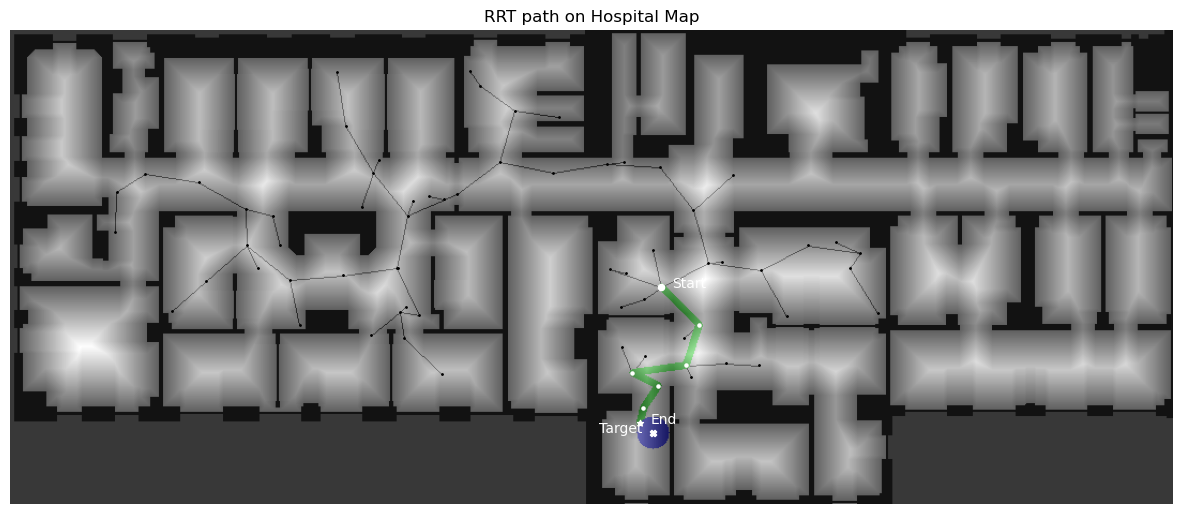

In [27]:
# Get random nodes from the uniform probabilistic roadmap because there are already in the free space
start_node, target_node = get_random_nodes(uniform_probalistic_roadmap)

# Caclulate the RRT graph
max_iterations = 5000
max_distance = 50
goal_radius = 15
threshold = 5
rrt_path, rrt_graph, start_node, target_node_new = rrt(image_normal, start_node, target_node, max_iterations, max_distance, goal_radius, threshold)
if rrt_path != None:
    print('Visited nodes: ', len(rrt_graph.nodes))
    print('Path length: ', len(rrt_path))
    show_rrt_path(rrt_graph, rrt_path, start_node, target_node_new, target_node, image, brushfire_map, title='RRT path on Hospital Map', goal_radius=goal_radius)
else:
    print('RRT could not find a path')

# Task 7 - RRT* [0.5]

Έχοντας ως είσοδο δύο κόμβους του γράφου, υλοποιήστε τον αλγόριθμο `RRT*`, ο οποίος θα πρέπει να επιστρέφει το μονοπάτι από τον ένα κόμβο προς τον άλλον. Επίσης σχεδιάστε το `RRT*` στην αρχική εικόνα και εμφανίστε το.

Σχόλιο: Εκτελέστε 2N επαναλήψεις, όπου Ν ο αριθμός επαναλήψεων κατά τον οποίο βρέθηκε ο στόχος.

In [28]:
# Create a class of a node that contains it's id, x and y coordinates and a list of neighbors
class Tree_Node_RRT_star:
  def __init__(self, id, x, y):
    self.id = id
    self.x = x
    self.y = y
    self.parent = None 
    self.cost = np.inf

In [54]:
# Create RRT algorithm
def rrt_star(image, start_node, target_node, max_iterations, max_distance, search_radius, goal_radius, threshold):
    # Create a graph
    graph = Graph()
    # Create a list for the nodes
    nodes = []
    # Initialize node id
    node_id = 0
    # Create start node
    start_node = Tree_Node_RRT_star(node_id, start_node.x, start_node.y)
    start_node.cost = 0
    graph.nodes.append(start_node)
    # Add the start node to the list of nodes
    nodes.append(start_node)
    # initialize the number of iterations
    i = 0
    # Initialize flag found path
    found_end_node = False
    # Loop until the maximum number of iterations and select random points
    while i < max_iterations and found_end_node == False:
        # Peak a random node from the list of nodes
        random_x = np.random.randint(0, image.shape[1])
        random_y = np.random.randint(0, image.shape[0])
        # Find the closent neighbor to the random point
        closest_distance = np.inf
        closest_neighbor = None
        for node in nodes:
            current_distance = np.sqrt((random_x - node.x)**2 + (random_y - node.y)**2)
            # If the new node has smaller distance than the current closest node then update the closest node and the closest distance
            if current_distance < closest_distance:
                    closest_neighbor = node
                    closest_distance = current_distance
        # If the closest neighbor is not None then find the point with the max distance from the closest neighbor to the random point
        if closest_neighbor is not None:
            point_x , point_y = find_max_distance_point(closest_neighbor.x, closest_neighbor.y, random_x, random_y, max_distance)
            # Check if the point is not inside an obstacle and brushfire is bigger than the threshold and if the line from the node to the point does not intersect with any obstacle
            if image[point_y, point_x] != 0 and brushfire_map[point_y, point_x] > threshold and check_line_intersection(closest_neighbor.x, closest_neighbor.y, point_x, point_y, image, brushfire_map ,threshold) == False:
                # Create a new node
                node_id += 1
                new_node = Tree_Node_RRT_star(node_id, point_x, point_y)
                
                # Search for all the near nodes inside the search radius from the new node
                near_nodes = []
                for node in nodes:
                    if np.sqrt((point_x - node.x)**2 + (point_y - node.y)**2) <= search_radius:
                        near_nodes.append(node)
                        
                if near_nodes != []:
                    # Find the minimum cost node from the near nodes
                    min_cost = np.inf
                    for node in near_nodes:
                        # Calculate the cost based on the current examined node
                        new_cost = node.cost + np.sqrt((point_x - node.x)**2 + (point_y - node.y)**2)
                        # If cost is smaller and the new connected line does not overlap wall then update min cost and the parent of the new node
                        if new_cost < min_cost and check_line_intersection(node.x, node.y, point_x, point_y, image, brushfire_map, threshold) == False:
                            min_cost = new_cost
                            new_node.cost = new_cost
                            new_node.parent = node
                            
                    # Update the parents of the near nodes if smaller costs are found
                    for node in near_nodes:
                        # Calculate the cost based on the new node
                        new_cost = new_node.cost + np.sqrt((node.x - new_node.x)**2 + (node.y - new_node.y)**2)
                        # If cost is smaller and the new connected line does not overlap wall then the new node provides a better path to the near node, so update the cost and the parent of the near node 
                        if new_cost < node.cost and check_line_intersection(node.x, node.y, new_node.x, new_node.y, image, brushfire_map, threshold) == False:
                            node.cost = new_cost
                            node.parent = new_node
                else:
                    # Update his parent and cost
                    new_node.parent = closest_neighbor
                    new_node.cost = closest_neighbor.cost + np.sqrt((point_x - closest_neighbor.x)**2 + (point_y - closest_neighbor.y)**2)
                    
                
                # Add the new node to the list of nodes
                nodes.append(new_node)
                # Add the new node to the graph
                graph.nodes.append(new_node)
                # 
                # If the new node is close to the target node then end the algorithm and return the path
                if np.sqrt((point_x - target_node.x)**2 + (point_y - target_node.y)**2) <= goal_radius:
                    print('RRT* found a path')
                    # Return the path
                    found_end_node = True
            # Increment i
            i += 1
        else:
            # Decrease i and reiterate
            i -= 1
            
    if found_end_node == True:
        path = []
        current_node = graph.nodes[-1]
        path.append(current_node.id)
        start_node = graph.nodes[0]
        target_node = graph.nodes[-1]
        
        while current_node.parent != None:
            path.append(current_node.parent.id)
            current_node = current_node.parent
        
        return path, graph, start_node, target_node
        
    return None, graph, start_node, target_node


RRT* found a path
Visited nodes:  1913
Path length:  11


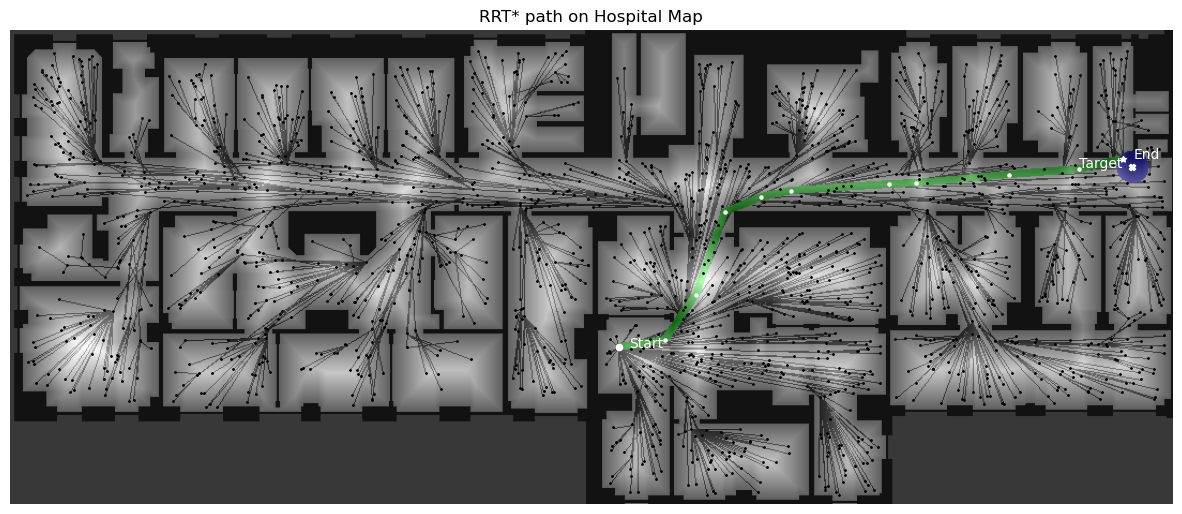

In [55]:
# Get random nodes from the uniform probabilistic roadmap because there are already in the free space
start_node, target_node = get_random_nodes(uniform_probalistic_roadmap)

# Caclulate the RRT graph
max_iterations = 5000
max_distance = 50
search_radius = 100
goal_radius = 15
threshold = 5
rrt_star_path, rrt_star_graph, start_node, target_node_new = rrt_star(image_normal, start_node, target_node, max_iterations, max_distance, search_radius, goal_radius, threshold)
if rrt_star_path != None:
    print('Visited nodes: ', len(rrt_star_graph.nodes))
    print('Path length: ', len(rrt_star_path))
    show_rrt_path(rrt_star_graph, rrt_star_path, start_node, target_node_new, target_node, image, brushfire_map, title='RRT* path on Hospital Map', goal_radius=goal_radius)
else:
    print('RRT could not find a path')

# Task 8 - Path smoothing [0.25]

Έχοντας ως είσοδο ένα μονοπάτι, υλοποιήστε μέθοδο που θα το ομαλοποιεί με χρήση της μεθόδου gradient descent (ή όποιας άλλης επιθυμείτε). Στο τέλος, θα πρέπει να δείξετε το αρχικό μονοπάτι και το smoothed.

In [60]:
from scipy import interpolate

In [65]:
# This is a function to generate random points to test the path smoothing algorithm
x = []
y = []
for i in range(0,30,5):
    x.append(i)
    y.append(random.randint(0, 10))

In [66]:
# Create a function to smooth the path using b-spline interpolation
def smooth_path(x, y, s=0.1, k=3, n=100):
    # Create a tck tuple
    tck, u = interpolate.splprep([x, y], s=s, k=k)
    # Create a new set of points
    unew = np.linspace(u.min(), u.max(), n)
    out = interpolate.splev(unew, tck)
    return out

In [81]:
smooth_path_x, smooth_path_y = smooth_path(x, y, s=0.5, k=2, n=len(x)*5)

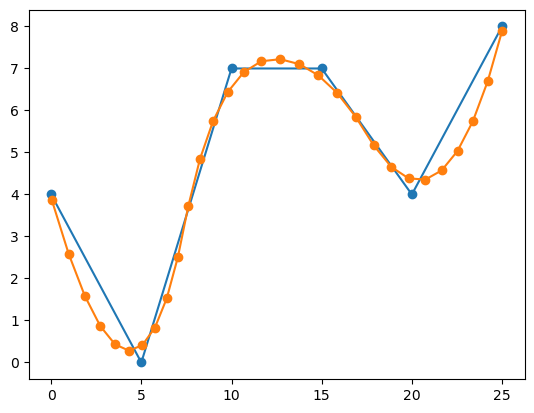

In [82]:
# This is a function to generate random points to test the path smoothing algorithm
plt.plot(x, y, '-o');
plt.plot(smooth_path_x, smooth_path_y, '-o');

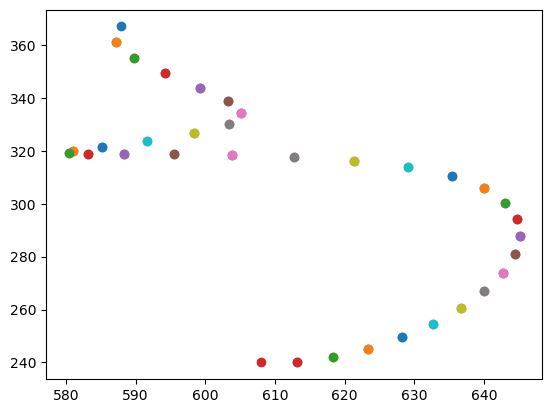

In [96]:
x = []
y = []
for index in rrt_path:
    x.append(rrt_graph.nodes[index].x)
    y.append(rrt_graph.nodes[index].y)
smooth_path_x, smooth_path_y = smooth_path(x, y, s=0.1, k=3, n=len(x)*5)
for i in range(len(smooth_path_x)-1):
    plt.scatter([smooth_path_x[i], smooth_path_x[i+1]], [smooth_path_y[i], smooth_path_y[i+1]])